# Common

In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from numba import jit

In [2]:
from scipy.io import wavfile
# samplerate, data = wavfile.read('Antonio_Vivaldi_summer_storm.wav')
samplerate, data = wavfile.read('storm_4_sec.wav')

In [3]:
import time
import sounddevice as sd

def play(data, samplerate, t=0.1):
    if t is None:
        t = data.shape[0] / samplerate
    sd.play(data, samplerate)
    time.sleep(t)
    sd.stop()

In [4]:
play(data, samplerate)

# Helpers

In [5]:
INT_SIZE = 4 * 8

def str2bin(s):
    binary = np.empty((len(s),), dtype=np.uint8)
    for i, c in enumerate(s):
        binary[i] = ord(c)
    return np.unpackbits(binary).astype(np.bool)

def bin2str(binary):
    binary = np.packbits(binary)
    s = ''
    for c in binary:
        s += chr(c)
    return s


def put_size(hidden_data):
    size = len(hidden_data)
    hidden_data_with_size = np.empty((INT_SIZE + hidden_data.size,), dtype=np.bool)
    hidden_data_with_size[INT_SIZE:] = hidden_data
    hidden_data_with_size[:INT_SIZE] = False
    i = 0
    while size > 0:
        hidden_data_with_size[i] = size % 2 == 1
        i += 1
        size //= 2
    return hidden_data_with_size


def bin2int(binary_array):
    assert len(binary_array) == INT_SIZE
    base = 1
    x = 0
    for i in range(min(INT_SIZE, len(binary_array))):
        base = 2**i
        x += base * binary_array[i]
    return x


def SNR(data, stego):
    error = data.astype(np.int64) - stego.astype(np.int64)
    return 10*np.log10(np.mean(data.astype(np.int64)**2) / np.mean(error.astype(np.int64)**2))


def print_diff(original, stego):
    print('Number of samples:', original.size)
    print('Maximum difference is:', np.max(np.abs(original - stego)))
    print('Sum     difference is:', np.sum(np.abs(original - stego)))
    print('Average difference is:', np.mean(np.abs(original - stego)))

# Low-bit encoding

In [6]:
NEXT_POWER_OF_2 = 6
assert NEXT_POWER_OF_2 > 0
UINT_BIT_SIZE = 15

def lbe_count_hidden_size(data):
    count = 0
    for bit in range(UINT_BIT_SIZE):
        lower = 2**(bit + NEXT_POWER_OF_2)
        count += np.sum(np.logical_or(data >= lower, data < -lower))
        # count += np.sum(data >= lower)
    return count - INT_SIZE


def lbe_put_hidden_data(data, hidden_data):
    if lbe_count_hidden_size(data) < len(hidden_data):
        raise Exception("Not enough space in the data")

    hidden_data = put_size(hidden_data)
    stego_data = np.array(data).astype(np.uint16)

    for bit in range(UINT_BIT_SIZE):
        lower = 2**(bit + NEXT_POWER_OF_2)
        mask = np.logical_or(data >= lower, data < -lower)
        # mask = data >= lower
        changeable = stego_data[mask]
        n = min(len(changeable), len(hidden_data))
        changeable[:n] = np.bitwise_and(changeable[:n], 2**16 - 1 - 2**bit)
        changeable[:n] = np.bitwise_or(changeable[:n], 2**bit * hidden_data[:n])
        stego_data[mask] = changeable
        hidden_data = hidden_data[n:]
        if len(hidden_data) == 0:
            break
    else:
        raise Exception("Unhelded: Not enough space in the data")

    return stego_data.astype(np.int16)


def lbe_get_hidden_data(stego):
    stego_data = np.array(stego).astype(np.uint16)
    size = []
    
    # Extract size
    for bit in range(UINT_BIT_SIZE):
        lower = 2**(bit + NEXT_POWER_OF_2)
        mask = np.logical_or(stego >= lower, stego < -lower)
        # mask = stego >= lower
        with_data = stego_data[mask]
        n = min(len(with_data), INT_SIZE - len(size))
        for x in np.bitwise_and(with_data[:n], 2**bit):
            size.append(x > 0)
        if len(size) == INT_SIZE:
            break
    size = bin2int(size)

    # Extract all hidden data
    from_idx = 0
    hidden_data = np.empty((INT_SIZE + size,), dtype=np.bool)
    for bit in range(UINT_BIT_SIZE):
        lower = 2**(bit + NEXT_POWER_OF_2)
        mask = np.logical_or(stego >= lower, stego < -lower)
        # mask = stego >= lower
        with_data = stego_data[mask]
        n = min(len(with_data), len(hidden_data) - from_idx)
        to_idx = from_idx + n
        # print(np.bitwise_and(with_data[:n], 2**bit))
        hidden_data[from_idx:to_idx] = np.bitwise_and(with_data[:n], 2**bit) > 0
        from_idx = to_idx
        if from_idx == len(hidden_data):
            break
    return hidden_data[INT_SIZE:]

In [7]:
def check_str(s):
    hidden_data = str2bin(s)
    stego = lbe_put_hidden_data(data, hidden_data)
    restored_hidden_data = lbe_get_hidden_data(stego)
    restored_s = bin2str(restored_hidden_data)
    return s == restored_s

def check_random(n):
    hidden_data = np.random.randint(0, 2, size=n, dtype=np.bool)
    stego = lbe_put_hidden_data(data, hidden_data)
    restored_hidden_data = lbe_get_hidden_data(stego)
    return np.all(hidden_data == restored_hidden_data)

In [8]:
max_size = lbe_count_hidden_size(data)
file_size = data.size * 16
print(f'Can be stored {max_size} bits, which is approximately {max_size / file_size * 100 :.1f}% of an original file')

Can be stored 1892087 bits, which is approximately 33.5% of an original file


In [9]:
15 * 8 // 4

30

In [10]:
assert check_str("Hello!")
assert check_random(1000)
assert check_random(max_size)

### You can hear resulting audio if we put a random data to it 

In [12]:
max_size = lbe_count_hidden_size(data)
hidden_data = np.random.randint(0, 2, size=max_size, dtype=np.bool)
stego = lbe_put_hidden_data(data, hidden_data)
play(stego, samplerate)

### Or you can put a string and restore it

In [13]:
s_original = 'Hello, World!'
hidden_data = str2bin(s_original)
stego = lbe_put_hidden_data(data, hidden_data)

In [16]:
# Check that hidden data can be restored after saving data
wavfile.write('stego.wav', samplerate, stego)
_, stego = wavfile.read('stego.wav')
play(stego, samplerate)

In [17]:
hidden_data = lbe_get_hidden_data(stego)
s_restored = bin2str(hidden_data)
print(f'Restored string is "{s_restored}"')

Restored string is "Hello, World!"


# Echo hiding

Filter transfer function:
$$H_0(z) = 1 + a_0 z^{-d_0}$$
**Let's firstly hear and echo with amplitude 0.5 and delay 1 second.**

In [18]:
delay_s = 1
delay = round(samplerate * delay_s)
ampl = 0.4

num = [1] + [0] * (delay - 1) + [ampl]
den = [1]

In [19]:
echoed = np.empty(data.shape, dtype=data.dtype)
echoed[:, 0] = signal.lfilter(num, den, data[:, 0])
echoed[:, 1] = signal.lfilter(num, den, data[:, 1])

In [20]:
# echoed sound
play(echoed, samplerate)

**Now we will try to find that the delay in echoed audio is really 1 second**

Firstly, let's find a setstrum:
$$IFFT\{ln(|FFT\{x\}|^2)\}$$

In [21]:
cepstrum = np.empty(echoed.shape, dtype=np.float64)
for i in range(2):
    cepstrum[:, i] = np.fft.irfft(np.log(np.abs(np.fft.rfft(echoed[:, i]))**2))

In [22]:
autocorrelation = signal.correlate(cepstrum[:, 0], cepstrum[:, 0], mode='full')
autocorrelation = autocorrelation[autocorrelation.size // 2:]

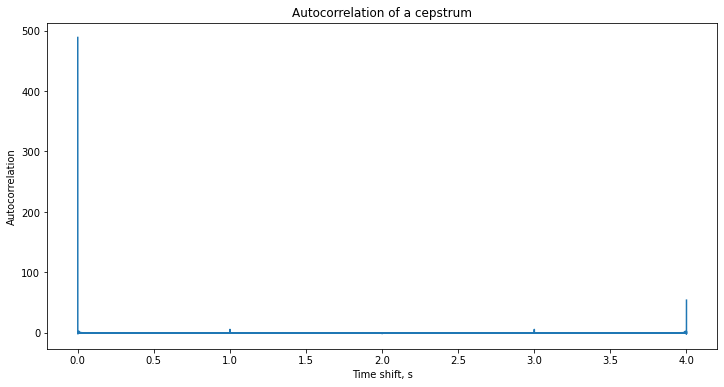

In [23]:
plt.figure(figsize=(12, 6))

plt.plot(np.arange(autocorrelation.size) / samplerate, autocorrelation)

plt.title('Autocorrelation of a cepstrum')
plt.ylabel('Autocorrelation')
plt.xlabel('Time shift, s')

plt.show()

**We can see a pick around 1s**

# Implementation

In [24]:
@jit
def echo_signal(signal, delay, ampl):
    echoed = np.empty(signal.shape, dtype=np.float64)
    echoed[:delay] = signal[:delay]
    # for i in range(delay, len(signal)):
    #     echoed[i] = signal[i] + ampl * echoed[i - delay]
    echoed[delay:] = signal[delay:] + ampl * signal[:-delay]
    return echoed

def cepstrum(signal):
    return np.fft.irfft(np.log(np.abs(np.fft.rfft(signal))))

def autocorrelation(x):
    ac = signal.correlate(x, x, mode='full')
    return ac[ac.size // 2:]

def decode_bit(signal, delay):
    ac0 = autocorrelation(cepstrum(signal[:, 0]))
    ac1 = autocorrelation(cepstrum(signal[:, 1]))
    return ac0[delay[1]] + ac1[delay[1]] > ac0[delay[0]] + ac1[delay[1]]
    # return ac1[delay[1]] > ac1[delay[0]]

def get_mixer(hidden_data, size, transition_len):
    mixer = np.empty(size, dtype=np.float64)
    msg_len = len(hidden_data)
    for i in range(len(hidden_data)):
        from_idx = i * size //  len(hidden_data)
        to_idx = (i + 1) * size // len(hidden_data)
        mixer[from_idx:to_idx] = hidden_data[i]
        if i > 0 and hidden_data[i - 1] != hidden_data[i]:
            # Add transition
            transition_left = i * size //  len(hidden_data) - transition_len // 2
            transition_right = transition_left + transition_len
            transition = np.linspace(hidden_data[i - 1], hidden_data[i], num=transition_len)
            mixer[transition_left:transition_right] = transition
    return mixer


def eh_count_hidden_size(data, delay):
    size = data.shape[0]
    return size // (30 * max(delay))


SKIP_FIRST = 3

def eh_put_hidden_data(data, hidden_data, delay, ampl):
    # if eh_count_hidden_size(data, delay) < len(hidden_data):
    #     raise Exception("Not enough space")
    new_hidden_data = np.empty((len(hidden_data) + SKIP_FIRST,), dtype=np.bool)
    new_hidden_data[SKIP_FIRST:] = hidden_data
    hidden_data = new_hidden_data

    echoed = [echo_signal(data, delay[i], ampl) for i in range(2)]
    mixer = get_mixer(hidden_data, data.shape[0], transition_len=max(delay))
    stego = mixer[:, np.newaxis] * echoed[1] + (1 - mixer)[:, np.newaxis] * echoed[0]
    return stego.astype(np.int16)


def eh_get_hidden_data(stego, hidden_data_size, delay):
    hidden_data_size += SKIP_FIRST

    size = stego.shape[0]
    hidden_data = np.empty((hidden_data_size,), dtype=np.bool)
    transition_len=max(delay)
    for i in range(hidden_data_size):
        from_idx = i * size //  hidden_data_size
        from_idx += transition_len // 2
        to_idx = (i + 1) * size // hidden_data_size
        to_idx -= transition_len // 2
        stego_part = stego[from_idx:to_idx]
        bit = decode_bit(stego_part, delay)
        hidden_data[i] = bit
    return hidden_data[SKIP_FIRST:]

In [25]:
delay_sec = [8e-4, 1e-3]
delay = [round(samplerate * d) for d in delay_sec]
ampl = 0.4

In [26]:
eh_count_hidden_size(data, delay)

133

In [27]:
s_original = 'Secrete message!'
hidden_data = str2bin(s_original)
hidden_data_size = len(hidden_data)

In [28]:
stego = eh_put_hidden_data(data, hidden_data, delay, ampl)

In [29]:
play(stego, samplerate)
print(f'SNR is equal to {SNR(data, stego):.2f}dB')

SNR is equal to 7.97dB


In [30]:
restored_hidden_data = eh_get_hidden_data(stego, hidden_data_size, delay)
s_restored = bin2str(restored_hidden_data)
print(f'Restored message "{s_restored}"')
assert s_restored == s_original

Restored message "Secrete message!"


In [31]:
delay_sec = [8e-4, 1e-3]
delay = [round(samplerate * d) for d in delay_sec]

ampl = 0.4
echoed = [echo_signal(data[:2000], delay[i], ampl) for i in range(2)]

In [32]:
ac0 = autocorrelation(cepstrum(echoed[0][:, 1]))
ac1 = autocorrelation(cepstrum(echoed[1][:, 1]))

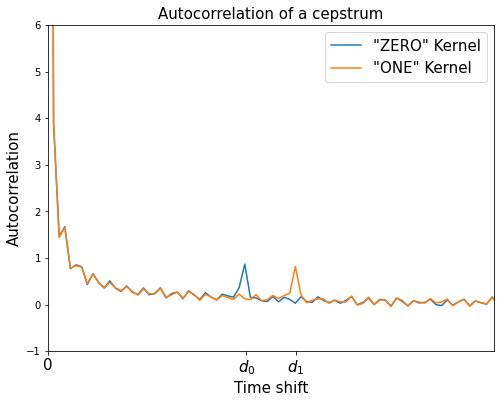

In [33]:
plt.figure(figsize=(8, 6))

plt.plot(np.arange(ac0.size) / samplerate, ac0, label='"ZERO" Kernel')
plt.plot(np.arange(ac1.size) / samplerate, ac1, label='"ONE" Kernel')

plt.title('Autocorrelation of a cepstrum', fontsize=15)
plt.ylabel('Autocorrelation', fontsize=15)
plt.xlabel('Time shift', fontsize=15)

plt.ylim(-1, 6)
plt.xlim(0, 1.8e-3)

plt.xticks([0, delay_sec[0], delay_sec[1]], ['0', '$d_0$', '$d_1$'], fontsize=15)

plt.legend(fontsize=15)

plt.show()

**Let's try to store into mp3 and then restore the message**

In [34]:
s_original = 'Secrete message!'
hidden_data = str2bin(s_original)
hidden_data_size = len(hidden_data)

In [35]:
stego = eh_put_hidden_data(data, hidden_data, delay, ampl)


In [36]:
play(stego, samplerate)

In [42]:
import subprocess
wav = 'stego.wav'
mp3 = 'stego.mp3'
wav_restored = 'stego.mp3.wav'
cmd_wav_mp3 = f'lame --preset medium {wav} {mp3}'
cmd_mp3_wav = f'lame --decode {mp3} {wav_restored}'

wavfile.write('stego.wav', samplerate, stego)
subprocess.call(cmd_wav_mp3, shell=True)
subprocess.call(cmd_mp3_wav, shell=True)
_, stego = wavfile.read('stego.mp3.wav')

In [43]:
play(stego, samplerate)

In [44]:
hidden_data = eh_get_hidden_data(stego, hidden_data_size, delay)
s_restoread = bin2str(hidden_data)
print(f'Restored message "{s_restored}"')
assert s_restored == s_original

Restored message "Secrete message!"


# Phase hiding

In [45]:
fname_in = 'storm_4_sec.wav'

In [46]:
rate, data = wavfile.read(fname_in)
data = data.copy()

In [47]:
msg = 'super secret massage!'

In [48]:
def bit_rate(msg):
    hid_data = str2bin(msg)
    hid_data_size = len(hidden_data)
    bt_rate = hid_data_size/4
    return bt_rate

In [49]:
def SNR(data, stego):
    data = data[:, 0]
    stego = stego[:,0]
    
    data = data.astype(np.int64)
    stego = stego.astype(np.int64)
    
    lenn = min(len(data), len(stego))
    data = data[:lenn]
    stego = stego[:lenn]
    
    error = data.astype(np.int64) - stego.astype(np.int64)
    out = 10*np.log10(np.mean(data.astype(np.int64)**2) / np.mean(error.astype(np.int64)**2))
    return out

### Encode

In [50]:
def divide_input_signal(msg, data):
    msglen = 8 * len(msg)
    seglen = int(2 * 2**np.ceil(np.log2(2*msglen))) #segmenr_width
    segnum = int(np.ceil(data.shape[0]/seglen)) #segment_count
    
    if len(data.shape) == 1:
        data.resize(segnum*seglen, refcheck=False)
        data = data[np.newaxis]
    else:
        data.resize((segnum*seglen, data.shape[1]), refcheck=False)
        data = data.T
    return segnum, seglen, data, msglen

def signal2mag_phase(data, segnum, seglen):
    segs = data[0].reshape((segnum,seglen))  
    segs = np.fft.fft(segs)
    M = np.abs(segs)
    P = np.angle(segs)
    return M,P, segs

def encode_msg2bin(msg):
    msgbin = np.ravel([[int(y) for y in format(ord(x), '08b')] for x in msg])
    msgPi = msgbin.copy()
    msgPi[msgPi == 0] = -1
    msgPi = msgPi * -np.pi/2
    return msgPi

def shift_ph_sequence (P,seglen,msgPi,msglen):
    dP = np.diff(P, axis=0)
    segmid = seglen // 2
    P[0,-msglen+segmid:segmid] = msgPi
    P[0,segmid+1:segmid+1+msglen] = -msgPi[::-1]
    for i in range(1, len(P)): 
        P[i] = P[i-1] + dP[i-1]
    return P

def reconstruct_signals(segs, M, P, rate, data):
    segs = (M * np.exp(1j * P))
    segs = np.fft.ifft(segs).real
    data[0] = segs.ravel().astype(np.int16)
    return data

def encode_msg(msg,rate,data):
    segnum, seglen, data, msglen = divide_input_signal(msg, data)
    M,P, segs = signal2mag_phase(data, segnum, seglen)
    msgPi = encode_msg2bin(msg)
    P = shift_ph_sequence(P,seglen,msgPi,msglen)
    data = reconstruct_signals(segs, M, P, rate, data)
    wavfile.write('steg_'+fname_in, rate, data.T)
    return seglen, msglen

In [51]:
seglen, msglen = encode_msg(msg,rate,data)

### Decode

In [52]:
fname_out = 'steg_storm_4_sec.wav'

In [53]:
rate, stegg = wavfile.read(fname_out)
stegg = stegg.copy()

In [54]:
def decode_msg(msglen,data,seglen):
    if len(data.shape) == 1:
        x = data[:seglen]
    else:
        x = data[:seglen,0]
    segmid = seglen // 2
    x = (np.angle(np.fft.fft(x))[segmid-msglen:segmid] < 0).astype(np.int8)
    x = x.reshape((-1,8)).dot(1 << np.arange(8 - 1, -1, -1))
    msgg = ''.join(np.char.mod('%c',x))
    return msgg

In [55]:
msgg = decode_msg(msglen,stegg,seglen)
print(f'Restored string is "{msgg}"')

Restored string is "super secret massage!"


In [56]:
_, data = wavfile.read(fname_in)
_, stegg = wavfile.read(fname_out)

In [57]:
print(f'SNR is equal to {SNR(data, stegg):.2f}dB')

SNR is equal to 33.87dB
